# Bounded Clustering - A Clustering Algorithm for Bounded Sized Clusters

## This notebook was created to serve a [blog post](http://bit.ly/BoundedClustering) by the same name.

In [1]:
# written in python 3.7.3
import geojsonio
import json
import random
import time

from geojson import Point as GeojsonPoint, Feature, FeatureCollection
from shapely.geometry import Point as ShapelyPoint, Polygon
from sklearn.datasets import make_blobs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

random_seed = 314
random.seed(random_seed)
np.random.seed(random_seed)

## Step I - Bounded K-Means Clustering

In [2]:
class ClustersUtils:
    
    @classmethod
    def compute_dist_array(cls, X: np.array) -> np.array:
        dist_array = np.array([[np.linalg.norm(x1 - x2)
                                for x1 in X]
                               for x2 in X])
        return dist_array
    
    @classmethod
    def scatter_plot(cls, X: np.array, clusters_in_idxs: [[int]], centroid_idxs: [int] = None):
        """Only plots first two dimensions"""
        x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                          for one_cluster_in_idxs in clusters_in_idxs
                          for c_idx in one_cluster_in_idxs]))
        c = [color_idx
             for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
             for _ in one_cluster_in_idxs]
        df = pd.DataFrame({'x': x, 'y': y, 'c': c})

        fig, ax = plt.subplots()
        for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
            df_temp = df[df['c'].isin([color_idx])]
            plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5)

        if centroid_idxs is not None:
            x_c, y_c = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                                  for c_idx in centroid_idxs]))
            plt.plot(x_c, y_c, 'o', color='black', markersize=3)

        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
        
    @classmethod
    def plot_families_on_map(cls, points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        color = "#251782"
        for lng_lat, s in zip(points_coords_lng_lat, family_size):
            p = Feature(geometry=GeojsonPoint(lng_lat), 
                        properties={"marker-symbol": int(s), "marker-color": color})
            features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));
        
    @classmethod
    def plot_clustering_on_map(cls, clusters_in_idxs: [[int]], 
                               points_coords_lng_lat: [[float]], family_size: np.array) -> None:
        features = []
        for cluster_idxs in clusters_in_idxs:
            color = "#" + ''.join(random.choices('0123456789abcdef', k=6))
            for idx in cluster_idxs:
                properties = {"marker-symbol": int(family_size[idx]), "marker-color": color}
                p = Feature(geometry=GeojsonPoint(points_coords_lng_lat[idx]), properties=properties)
                features += [p]

        feature_collection = FeatureCollection(features=features)
        geojsonio.display(json.dumps(feature_collection));

In [3]:
class BoundedKMeansClustering:
    def __init__(self, n_clusters: int, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, plot_every_iteration=False):
        self.n_clusters = n_clusters
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.plot_every_iteration = plot_every_iteration

        self.n_points = None

    def fit(self, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        self.n_points = X.shape[0]
        dist_array = dist_array if dist_array is not None else ClustersUtils.compute_dist_array(X)

        costs, clusters = zip(*[self.fit_one_iteration(X, weights, dist_array) for _ in range(self.n_init)])

        if all(np.isnan(np.array(costs))):
            return np.nan, np.nan
        
        best_idx = np.nanargmin(costs)
        best_cost = costs[best_idx]
        best_clusters = clusters[best_idx]

        self.n_points = None
        return best_cost, best_clusters

    def fit_one_iteration(self, X: np.array, weights: np.array, dist_array: np.array) -> [float, [[int]]]:
        # inspired by https://core.ac.uk/download/pdf/61217069.pdf

        try:
            clusters_in_idxs = self._initialize_clusters(weights, dist_array)
            best_clusters = clusters_in_idxs
            best_cost = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)

            for i in range(self.n_iter):
                clusters_in_idxs, maximal_mean_dist_in_clusters = self._optimize_clusters(X, weights, dist_array,
                                                                                          clusters_in_idxs)
                if clusters_in_idxs == best_clusters:
                    # print(f"Reached a local optimum after {i} iterations.")
                    break
                
                if maximal_mean_dist_in_clusters < best_cost:
                    best_cost = maximal_mean_dist_in_clusters
                    best_clusters = clusters_in_idxs
                    
            if self.plot_every_iteration:
                ClustersUtils.scatter_plot(X, best_clusters)

        except ValueError:
            best_cost, best_clusters = np.nan, np.nan

        return best_cost, best_clusters

    def _initialize_clusters(self, weights: np.array, dist_array: np.array) -> [[int]]:
        centroid_idxs = random.sample(range(self.n_points), self.n_clusters)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        return clusters_in_idxs

    def _assign_points_to_clusters(self, weights: np.array, dist_array: np.array, centroid_idxs: [int]) -> [[int]]:
        clusters_in_idxs = [[c_idx] for c_idx in centroid_idxs]
        cluster_weights = np.array([weights[c_idx] for c_idx in centroid_idxs])

        sorted_points_idxs_by_weights = [i for i in np.argsort(-weights,  axis=0) if i not in centroid_idxs]
        for p_idx in sorted_points_idxs_by_weights:
            is_assigned = False
            sorted_cluster_idxs_by_dist = np.argsort(dist_array[p_idx][centroid_idxs])
            for c_idx in sorted_cluster_idxs_by_dist:
                if cluster_weights[c_idx] + weights[p_idx] <= self.max_cluster_size:
                    clusters_in_idxs[c_idx].append(p_idx)
                    cluster_weights[c_idx] += weights[p_idx]
                    is_assigned = True
                    break
            if not is_assigned:
                raise ValueError(
                    f"Point {p_idx} could not be assigned. Try with more than {self.n_clusters} clusters. "
                    f"Current_clusters in idxs: {clusters_in_idxs}")

        return clusters_in_idxs

    def _get_maximal_mean_dist_in_clusters(self, dist_array: np.array, clusters_in_idxs: [[int]]):
        mean_dist_in_all_clusters = [self._get_mean_dist_in_cluster(dist_array, one_cluster_in_idxs)
                                     for one_cluster_in_idxs in clusters_in_idxs]
        maximal_mean_dist_in_clusters = max(mean_dist_in_all_clusters)
        return maximal_mean_dist_in_clusters

    def _get_mean_dist_in_cluster(self, dist_array: np.array, cluster_in_idxs: [[int]]) -> float:
        cluster_sub_dist_array = dist_array[cluster_in_idxs, :][:, cluster_in_idxs]
        cluster_sub_dist_array_triu = np.triu(cluster_sub_dist_array)
        cluster_sub_dist_array_triu[cluster_sub_dist_array_triu == 0] = np.nan
        mean_dist_in_cluster = np.nanmean(cluster_sub_dist_array)
        return mean_dist_in_cluster

    def _optimize_clusters(self, X: np.array, weights: np.array, dist_array: np.array, clusters_in_idxs: [[int]]):
        centroid_idxs = self._update_centroids(X, clusters_in_idxs)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        maximal_mean_dist_in_clusters = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)        
        return clusters_in_idxs, maximal_mean_dist_in_clusters

    def _update_centroids(self, X: np.array, clusters_in_idxs: [[int]]) -> [int]:
        updated_centroid_idxs = [self._update_centroid_for_one_cluster(X, one_cluster_in_idxs)
                                 for one_cluster_in_idxs in clusters_in_idxs]
        return updated_centroid_idxs

    def _update_centroid_for_one_cluster(self, X: np.array, cluster_in_idxs: [int]) -> int:
        center = np.mean(X[cluster_in_idxs], axis=0)
        closest_point_idx_in_cluster = np.argmin(np.linalg.norm(X[cluster_in_idxs] - center, axis=1))
        closest_point_idx = cluster_in_idxs[closest_point_idx_in_cluster]
        return closest_point_idx

### Small test

Best partition to 3 clusters computed in 6.53 seconds.
Total weight = 506.76808685333776
Max_cluster_size = 171.0
Clusters weights: {0: 169.21187252782138, 1: 170.36540908040482, 2: 167.1908052451113}


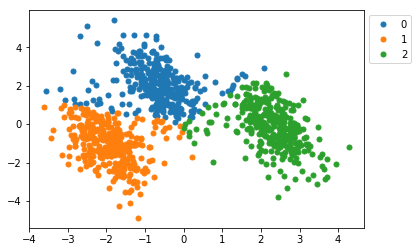

In [4]:
n_points = 1000
n_clusters = 3
n_iter = 10
n_init = 10

centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=n_points, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

weights = np.random.rand(n_points)
max_cluster_size = (sum(weights) // n_clusters) + n_clusters

t = time.time()
cluster_maker = BoundedKMeansClustering(n_clusters, max_cluster_size, n_iter, n_init)
best_cost, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition to {n_clusters} clusters computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

## Step II - The Elbow Method

In [5]:
class BoundedClustering:
    def __init__(self, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, n_k_to_try: int = 10, 
                 plot_every_iteration: bool = False, plot_edge_values: bool = False):
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.n_k_to_try = n_k_to_try
        self.plot_every_iteration = plot_every_iteration
        self.plot_edge_values = plot_edge_values

    def fit(self, X: np.array, weights: np.array) -> [float, [[int]]]:
        min_n_clusters = int(np.ceil(sum(weights) / self.max_cluster_size))
        max_n_clusters = min([min_n_clusters + self.n_k_to_try, len(weights)])
        all_k = list(range(min_n_clusters, max_n_clusters + 1))

        dist_array = ClustersUtils.compute_dist_array(X)
        costs, clusters = zip(*[self._fit_k(k, X, weights, dist_array) for k in all_k])

        if np.isnan(np.array(costs)).all():
            raise NotEnoughClustersException(f"Could not produce any clustering with range {all_k}.")

        valid_k_indices, all_points = zip(*[[i, np.array([k, cost])]
                                            for i, (k, cost) in enumerate(zip(all_k, costs))
                                            if not np.isnan(cost)])
        if len(valid_k_indices) <= 2:
            i = valid_k_indices[0]
            return all_k[i], clusters[i]

        p_left, p_right = all_points[0], all_points[-1]
        all_distances_from_line = [self._dist_from_line(p_left, p_right, p) for p in all_points]
        
        best_k_idx_in_all_points = int(np.argmax(all_distances_from_line))
        self._plot_elbow(all_points, best_k_idx_in_all_points)
        
        if self.plot_edge_values:
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[0]])
            ClustersUtils.scatter_plot(X, clusters[valid_k_indices[-1]])
        
        best_k_idx_in_all_ks = valid_k_indices[best_k_idx_in_all_points]
        best_n_clusters, best_clusters = all_k[best_k_idx_in_all_ks], clusters[best_k_idx_in_all_ks]
        return best_n_clusters, best_clusters
    
    def _fit_k(self, k: int, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        cluster_maker = BoundedKMeansClustering(k, self.max_cluster_size, self.n_iter, self.n_init)
        best_cost, best_clusters = cluster_maker.fit(X, weights, dist_array)
        return best_cost, best_clusters
    
    def _dist_from_line(self, p_left: np.array, p_right: np.array, p: np.array) -> float:
        # minus sign because we expect the point to be below the line
        d = -np.cross(p_right - p_left, p - p_left) / np.linalg.norm(p_right - p_left)
        return d
    
    def _plot_elbow(self, all_points, best_k_idx_in_all_points) -> None:
        points_list = np.array(all_points).T.tolist()
        plt.plot(points_list[0], points_list[1]);
        plt.plot([points_list[0][0], points_list[0][-1]], [points_list[1][0], points_list[1][-1]]);
        plt.scatter(all_points[best_k_idx_in_all_points][0], all_points[best_k_idx_in_all_points][1]);
        plt.xlabel('Number of clusters');
        plt.ylabel('Cost');
    
    

### Small test

Best partition was found for 6 clusters, computed in 20.48 seconds.
Total weight = 511.2482913669776
Max_cluster_size = 173.0
Clusters weights: {0: 97.90031090846036, 1: 96.42255909347881, 2: 80.65624662403664, 3: 70.45446174554765, 4: 89.84296561909079, 5: 75.97174737636331}


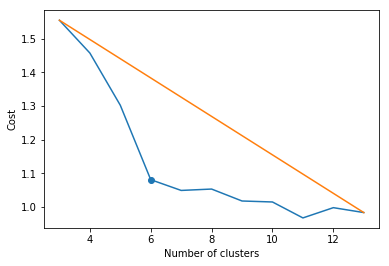

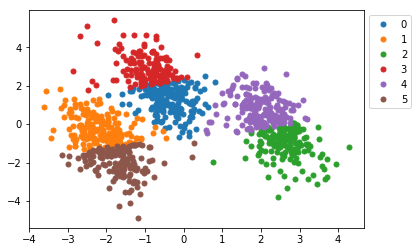

In [6]:
n_points = 1000
n_clusters = 3
n_iter = 10
n_init = 10

centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=n_points, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

weights = np.random.rand(n_points)
max_cluster_size = (sum(weights) // n_clusters) + n_clusters

t = time.time()
cluster_maker = BoundedClustering(max_cluster_size, n_iter, n_init)
best_k, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition was found for {best_k} clusters, computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

## Step III - Now with real data

#### To generate random input:
1. Sample random points around the city
2. Define a polygon of the neighberhood
3. Filter points outside the polygon
4. Smaple family sizes from a Poisson distribution

In [7]:
# 1. Sample random points around the city
n_points_before_filtering = 111
points_coords_lng_lat = [(34.895197 + (0.03 * random.random()), 32.174246 + (0.02 * random.random()))
                         for _ in range(n_points_before_filtering)]

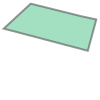

In [8]:
# 2. Define a polygon of the neighberhood
poly_coords_lng_lat = [(34.895948, 32.178923), (34.904274, 32.186623), (34.919810, 32.182772),
                       (34.924531, 32.181754), (34.921911, 32.172092)]
poly = Polygon(poly_coords_lng_lat)
poly

In [9]:
# 3. Filter points outside the polygon
points_coords_lng_lat = [p for p in points_coords_lng_lat if ShapelyPoint(p).within(poly)]
n_points = len(points_coords_lng_lat)
print(f"{n_points} families after filtering")

45 families after filtering


In [10]:
# 4. Smaple family sizes from a Poisson distribution
family_size = 1 + np.random.poisson(1, n_points)
print(f"Total number of people to transport: {sum(family_size)}")

Total number of people to transport: 82


In [11]:
ClustersUtils.plot_families_on_map(points_coords_lng_lat, family_size)

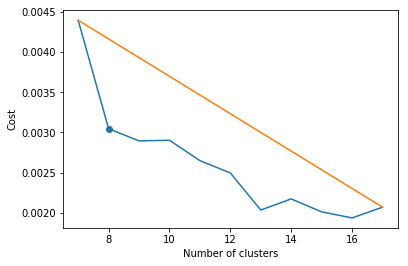

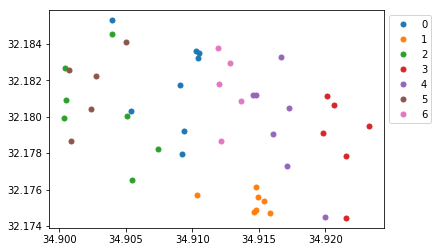

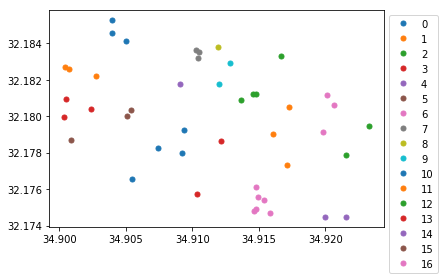

Minimal number of possible clusters is 7
Best partition was found for 8 clusters, computed in 9.03 seconds.
Total weight = 82
Max_cluster_size = 12
Clusters weights: {0: 12, 1: 11, 2: 11, 3: 11, 4: 11, 5: 12, 6: 2, 7: 12}


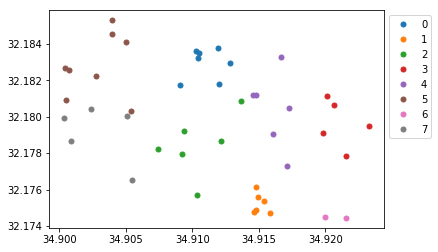

In [12]:
n_iter = 50
n_init = 10

max_cluster_size = 12
X = np.array(points_coords_lng_lat)
weights = family_size

t = time.time()
cluster_maker = BoundedClustering(max_cluster_size, n_iter, n_init, plot_edge_values=True)
best_k, best_clusters = cluster_maker.fit(X, weights)
print(f"Minimal number of possible clusters is {int(np.ceil(sum(weights) / max_cluster_size))}")
print(f"Best partition was found for {best_k} clusters, computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)
ClustersUtils.plot_clustering_on_map(best_clusters, points_coords_lng_lat, family_size)